In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## **Evaluate the node-level centralities graph-level properties**

In [1]:
from utils.evaluation import nodes_and_graph_properties
import networkx as nx
from functools import partial
from diffusion.jackson_metrics import diffusion_centrality, Godfather
from diffusion.complex_diffusion import paralell_complex_path
eigen = partial(nx.eigenvector_centrality, max_iter=1000, tol=1e-6)
degree = partial(nx.degree_centrality)
betwe = partial(nx.betweenness_centrality)
diffusion = partial(diffusion_centrality, T=10)
complex_path = partial(paralell_complex_path, T=0.5) 

names = ["degree_centrality",
         "betweenness centrality",
         "eigenvector_centrality",
         "diffusion_centrality",
         "complex_path_centrality"]

methods = [degree, betwe, eigen, diffusion, complex_path]

# lista = [["Planetoid","Cora"],
#          ["Planetoid", "CiteSeer"],
#          ["AttributedGraphDataset","facebook"],
#          ["AttributedGraphDataset","wiki"],
#          ["Twitch", "ES"]]
lista =[["LastFMAsia", "LastFMAsia"]]
         
for ttype, name in lista:
    node_level, graph_level = nodes_and_graph_properties(ttype, name, method_list=methods, method_names=names, save=True)


Gini Index: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1499.93it/s]


**Node-Centrality EDA**

In [2]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils.evaluation import node_level_load

datasets =["Cora", "CiteSeer", "facebook", "wiki", "ES", "LastFMAsia", "60"]

centralities = node_level_load(datasets)

In [25]:
df = prepare_data(centralities)

In [26]:
df

,node_index,degree_centrality,betweenness centrality,eigenvector_centrality,diffusion_centrality,complex_path_centrality,degree,dataset
0,0,0.573747,0.000141,4.865966e-03,0.167475,3.080773,3,Cora
1,1,0.573747,0.155655,5.084566e-03,0.132106,2.934348,3,Cora
2,2,0.956245,0.583566,7.231521e-02,0.557761,2.482286,5,Cora
3,3,0.191249,0.000000,3.977007e-31,0.030840,0.000000,1,Cora
4,4,0.956245,0.079403,2.485898e-01,0.429450,2.901789,5,Cora
...,...,...,...,...,...,...,...,...
17122,4643,0.789476,0.158405,9.279100e-01,0.964450,7.194522,39,ES
17123,4644,1.801625,0.375096,2.346405e+00,2.352039,6.592630,89,ES
17124,4645,0.364374,0.018189,6.195718e-01,0.603466,7.548157,18,ES
17125,4646,0.748990,0.037897,1.009492e+00,1.018546,7.187250,37,ES


Generating plots...
2. Creating violin plots...


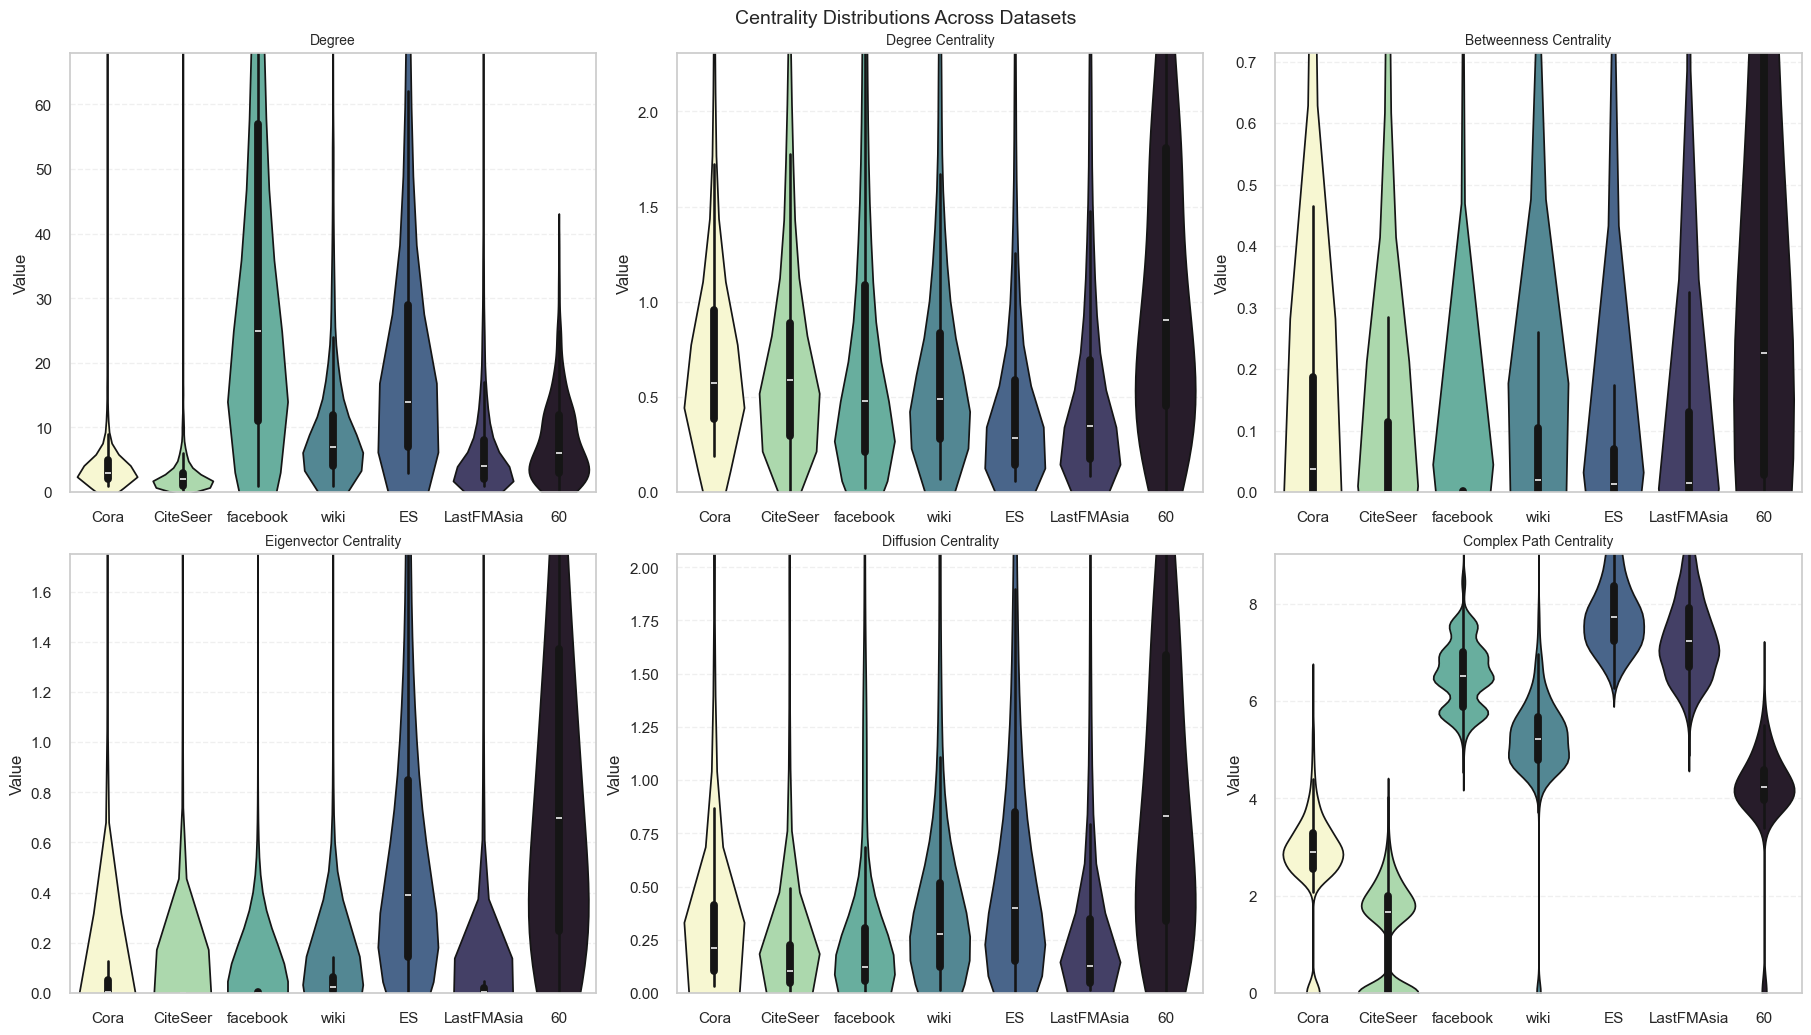

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import warnings
import os

# Create images directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Set the style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

def prepare_data(data_dict):
    """
    Prepare the data for visualization by creating a long-format DataFrame
    """
    all_data = []
    for dataset_name, df in data_dict.items():
        temp_df = df.copy()
        temp_df['dataset'] = dataset_name
        all_data.append(temp_df)
    return pd.concat(all_data, ignore_index=True)

def plot_boxplots(data_dict, percentile_cutoff=95):
    """
    Create and save boxplots for all metrics
    """
    combined_df = prepare_data(data_dict)
    metrics = ['degree', 'degree_centrality', 'betweenness centrality', 
               'eigenvector_centrality', 'diffusion_centrality', 
               'complex_path_centrality']

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Set up the figure and axes
        fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
        palette = cmo.deep(np.linspace(0, 1, len(data_dict)))
        
        for i, metric in enumerate(metrics):
            # Calculate the percentile cutoff for y-axis limit
            upper_limit = np.percentile(combined_df[metric], percentile_cutoff)
            
            row, col = divmod(i, 3)
            sns.boxplot(
                data=combined_df.loc[:,[metric, "dataset"]],
                x='dataset', y=metric, ax=axes[row, col],
                palette=palette
            )
            # Adjust y-axis limit and format
            axes[row, col].set_ylim(0, upper_limit)
            if upper_limit < 0.01:
                axes[row, col].yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
                axes[row, col].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
            
            # Improve title and labels
            clean_metric = metric.replace('_', ' ').title()
            axes[row, col].set_title(f'{clean_metric}\n(showing {percentile_cutoff}th percentile)', 
                                   fontsize=10)
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('Value')
            axes[row, col].tick_params(axis='x', rotation=45)
            
            # Add grid for better readability
            axes[row, col].grid(True, axis='y', linestyle='--', alpha=0.3)
    
        # General title and save the figure
        fig.suptitle('Distribution of Centrality Metrics Across Datasets', fontsize=16)
        plt.savefig('images/boxplots_all_metrics_2x3.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

def plot_violin_plots(data_dict, percentile_cutoff=95):
    """
    Create and save violin plots for each centrality measure with adjusted scales
    
    Parameters:
    -----------
    data_dict : dict
        Dictionary containing network datasets
    percentile_cutoff : int, optional
        Percentile to use for y-axis upper limit (default: 95)
    """
    combined_df = prepare_data(data_dict)
    metrics = ['degree','degree_centrality', 'betweenness centrality', 
              'eigenvector_centrality', 'diffusion_centrality', 
              'complex_path_centrality']
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
        
        for i, metric in enumerate(metrics):
            row, col = divmod(i, 3)
            
            # Calculate the percentile cutoff for y-axis limit
            upper_limit = np.percentile(combined_df[metric], percentile_cutoff)
            
            # Create violin plot
            sns.violinplot(
                data=combined_df.loc[:,[metric, "dataset"]],
                x='dataset', y=metric, ax=axes[row, col],
                palette=cmo.deep(np.linspace(0, 1, len(data_dict)))
            )
            
            # Adjust y-axis limit and format
            axes[row, col].set_ylim(0, upper_limit)
            if upper_limit < 0.01:
                axes[row, col].yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
                axes[row, col].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
            
            # Improve title and labels
            clean_metric = metric.replace('_', ' ').title()
            axes[row, col].set_title(f'{clean_metric}', 
                                   fontsize=10)
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('Value')
            axes[row, col].tick_params(axis='x')
            
            # Add grid for better readability
            axes[row, col].grid(True, axis='y', linestyle='--', alpha=0.3)
        
        # Remove empty subplot if exists
        if len(metrics) < 6:
            axes[1, 2].remove()
        
        # Add overall title
        fig.suptitle('Centrality Distributions Across Datasets', 
                    fontsize=14, y=1.02)
        
        # Save and show
        plt.savefig('images/violin_all_metrics_2x3.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()


def plot_correlation_heatmaps(data_dict):
    """
    Create and save correlation heatmaps for each dataset
    """
    metrics = ['degree','degree_centrality', 'betweenness centrality', 
              'eigenvector_centrality', 'diffusion_centrality', 
              'complex_path_centrality']
    
    for dataset_name, df in data_dict.items():
        plt.figure(figsize=(10, 8))
        corr = df[metrics].corr()
        sns.heatmap(corr, annot=True, cmap=cmo.thermal, fmt='.2f',
                    square=True, cbar=True)
        plt.title(f'{dataset_name} - Correlation Matrix', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(f'images/correlation_{dataset_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

def plot_scatter_comparisons(data_dict):
    """
    Create and save scatter plots comparing pairs of metrics
    """
    combined_df = prepare_data(data_dict)
    metrics = ['degree_centrality', 'betweenness centrality']
    colors = cmo.deep(np.linspace(0, 1, len(combined_df['dataset'].unique())))
    
    plt.figure(figsize=(10, 8))
    for idx, dataset in enumerate(combined_df['dataset'].unique()):
        dataset_data = combined_df[combined_df['dataset'] == dataset]
        plt.scatter(dataset_data[metrics[0]], dataset_data[metrics[1]], 
                   alpha=0.5, label=dataset, color=colors[idx])
    
    plt.xlabel(metrics[0])
    plt.ylabel(metrics[1])
    plt.title(f'Comparison of {metrics[0]} vs {metrics[1]}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('images/scatter_degree_vs_betweenness.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_density_plots(data_dict):
    """
    Create and save density plots for each metric
    """
    combined_df = prepare_data(data_dict)
    metrics = ['degree_centrality', 'betweenness centrality', 
              'eigenvector_centrality', 'diffusion_centrality', 
              'complex_path_centrality']
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for idx, dataset in enumerate(combined_df['dataset'].unique()):
            dataset_data = combined_df[combined_df['dataset'] == dataset]
            sns.kdeplot(data=dataset_data[metric], label=dataset)
        
        plt.title(f'{metric} Density Distribution', fontsize=14)
        plt.xlabel(metric)
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'images/density_{metric.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

def save_statistical_summary(data_dict):
    """
    Save statistical summary for each dataset and metric
    """
    combined_df = prepare_data(data_dict)
    metrics = ['degree_centrality', 'betweenness centrality', 
              'eigenvector_centrality', 'diffusion_centrality', 
              'complex_path_centrality']
    
    with open('images/statistical_summary.txt', 'w') as f:
        for dataset in combined_df['dataset'].unique():
            f.write(f"\nSummary for {dataset}:\n")
            dataset_data = combined_df[combined_df['dataset'] == dataset]
            f.write(dataset_data[metrics].describe().to_string())
            f.write("\n" + "="*50 + "\n")

# Generate all plots
def generate_all_plots(data_dict):
    """
    Generate and save all visualizations
    """
    print("Generating plots...")
    
    # print("1. Creating boxplots...")
    # plot_boxplots(data_dict)
    
    print("2. Creating violin plots...")
    plot_violin_plots(data_dict)
    
    # print("3. Creating correlation heatmaps...")
    # plot_correlation_heatmaps(data_dict)
    
    # print("4. Creating scatter plots...")
    # plot_scatter_comparisons(data_dict)
    
    # print("5. Creating density plots...")
    # plot_density_plots(data_dict)
    
    # print("6. Saving statistical summary...")
    # save_statistical_summary(data_dict)
    
    # print("All plots have been saved in the 'images' folder!")

# Run all visualizations
generate_all_plots(centralities)

## **Evaluate Graph-Level Properties**

In [55]:
properties

,Dataset,Average_Degree,Clustering_Coefficient,Gini_degree_centrality,Gini_betweenness centrality,Gini_eigenvector_centrality,Gini_diffusion_centrality,Gini_complex_path_centrality,Gini_degree
0,Cora,3.898080,0.240673,0.405139,0.819367,0.898096,0.633021,0.171421,0.405139
1,CiteSeer,2.736399,0.141471,0.443349,0.884013,0.954754,0.719303,0.431226,0.443349
2,facebook,43.691013,0.605547,0.541413,0.987386,0.941849,0.738876,0.075100,0.541413
3,wiki,10.612058,0.375812,0.495758,0.849727,0.890608,0.616839,0.087683,0.495758
4,ES,27.551635,0.222496,0.581728,0.870691,0.589631,0.582814,0.065706,0.581728


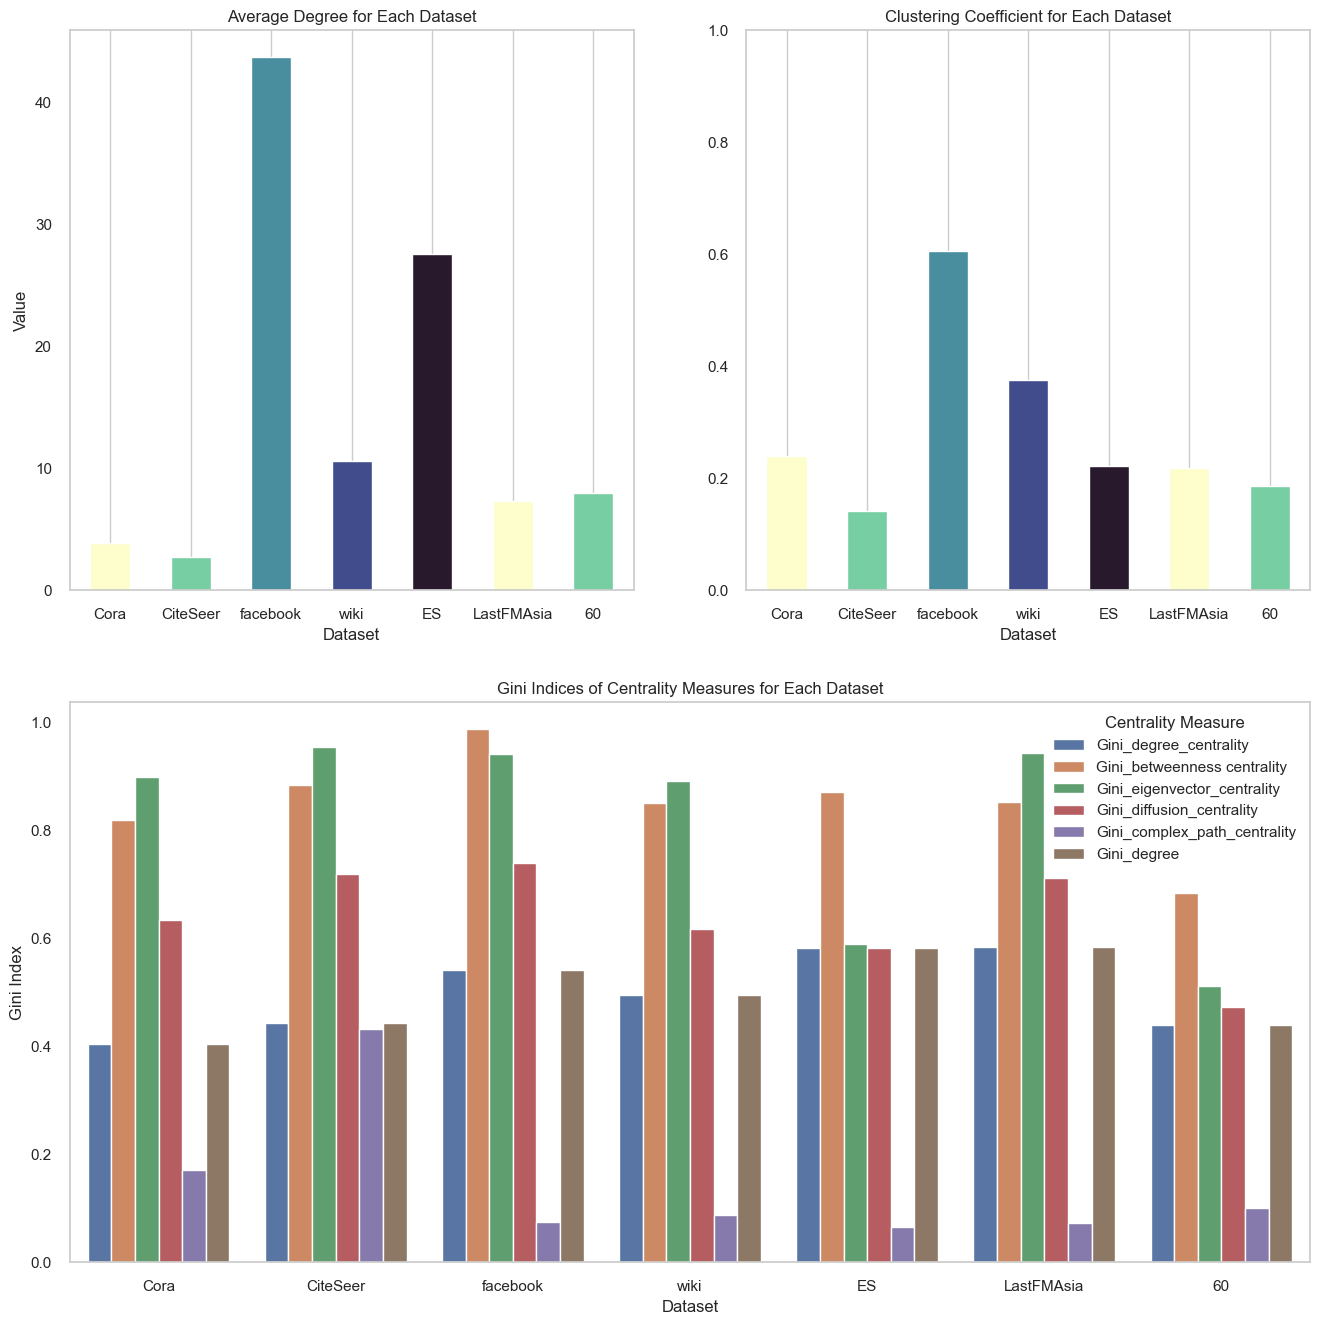

In [4]:
from utils.evaluation import graph_level_plot

# File paths for graph-level properties
datasets = ["Cora", "CiteSeer", "facebook", "wiki", "ES", "LastFMAsia", "60"]

properties = graph_level_plot(datasets, plot=True)